In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
from typing import *
from ckonlpy.tag import Twitter
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette("hls")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
train = pd.read_json("../arena_data/orig/train.json")
val_q_df = pd.read_json("../arena_data/questions/val.json") # val 데이터의 각 플레이스트를 50%로 분할

In [3]:
train_df = pd.concat([train, val_q_df])
train_df

,tags,id,plylst_title,songs,like_cnt,updt_date
0,"[힐링, 휴식, 밤, 새벽]",147668,To. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000
1,[팝],50422,130807-7,"[627035, 256438, 603324, 200889, 441319, 21689...",0,2013-08-15 13:17:11.000
2,[뉴에이지],116432,숙면을 위한 슬픈 마음을 달래 줄 피아노,"[129204, 369497, 649743, 344619, 110281, 63266...",23,2015-09-03 16:51:50.000
3,"[하드락, 록스피릿, 댄스]",55076,당신을 하얗게 불태울 곡들,"[677591, 420396, 104934, 119279, 251988, 58850...",1,2017-01-09 15:41:25.000
4,"[힐링, 휴식, 기분전환]",125064,[스피커 필수 / HIPHOP] 듣고 있음 꿀렁꿀렁이고 싶은 힙합음악!,"[704455, 694036, 508043, 154933, 57614, 645195...",715,2016-02-22 12:32:50.000
...,...,...,...,...,...,...
23010,[],132039,이것만 알아도 브릿팝 안다는 소리듣는다.,"[8778, 5725, 234307, 64368, 691112, 581349, 40...",232,2014-03-10 19:08:16.000
23011,[],21475,make015,"[470489, 72225, 387567, 328452, 517417, 690761...",0,2016-05-16 15:34:18.000
23012,"[힘들때, 지칠때, 힘내]",81196,"힘든 걸 알아, 말해주고 싶었어요","[448250, 131741, 531820, 616260, 639943, 13129...",13,2017-12-20 16:32:07.000
23013,[],151600,♥Christmas Music♥,[],8,2015-12-23 09:38:19.000


## 태그 형태소 분석

In [4]:
def flatten(list_of_list):
    flatten = [j for i in list_of_list for j in i]
    return flatten

def get_token(title: str, tokenizer):
    
    if len(title)== 0 or title== ' ':  # 제목이 공백인 경우 tokenizer에러 발생
        return []
    
    result = tokenizer.pos(title) 
    return result

def get_all_tags(df):
    tag_list = df['tags'].values.tolist()
    tag_list = flatten(tag_list)
    return tag_list

In [5]:
tokenizer = Twitter()
all_tag = get_all_tags(train_df)
token_tag = [get_token(x, tokenizer) for x in all_tag]  # 태그를 형태소 분석

In [6]:
token_tag[:10]

[[('힐링', 'Noun')],
 [('휴식', 'Noun')],
 [('밤', 'Noun')],
 [('새벽', 'Noun')],
 [('팝', 'Noun')],
 [('뉴에이지', 'Noun')],
 [('하드락', 'Noun')],
 [('록', 'Noun'), ('스피릿', 'Noun')],
 [('댄스', 'Noun')],
 [('힐링', 'Noun')]]

In [7]:
token_itself = list(filter(lambda x: len(x)==1, token_tag))  # 태그 자체가 형태소여서 분리되지 않는 태그만 골라봅니다
token_itself = flatten(token_itself)
flatten_token = flatten(token_tag)

In [8]:
print('%-23s'%'# of original tag is', f'{len(all_tag):8,}')
print('%-23s'%'# of morpheme itself is', f'{len(token_itself):8,}')
print('%-23s'%'# of total token is', f'{len(flatten_token):8,}')

# of original tag is     408,069
# of morpheme itself is  298,506
# of total token is      551,031


In [9]:
# Counting Part of Speech (pos)
pos = [x[1] for x in flatten_token]
pos_count = Counter(pos)
popular_pos = pos_count.most_common()

In [10]:
popular_pos[:20]

[('Noun', 444316),
 ('Alpha', 26908),
 ('Josa', 24858),
 ('Adjective', 18936),
 ('Verb', 16405),
 ('Number', 6617),
 ('Modifier', 6185),
 ('Punctuation', 2935),
 ('Adverb', 2353),
 ('Suffix', 593),
 ('Determiner', 336),
 ('Exclamation', 221),
 ('VerbPrefix', 135),
 ('Eomi', 121),
 ('Foreign', 76),
 ('KoreanParticle', 18),
 ('PreEomi', 16),
 ('Conjunction', 2)]

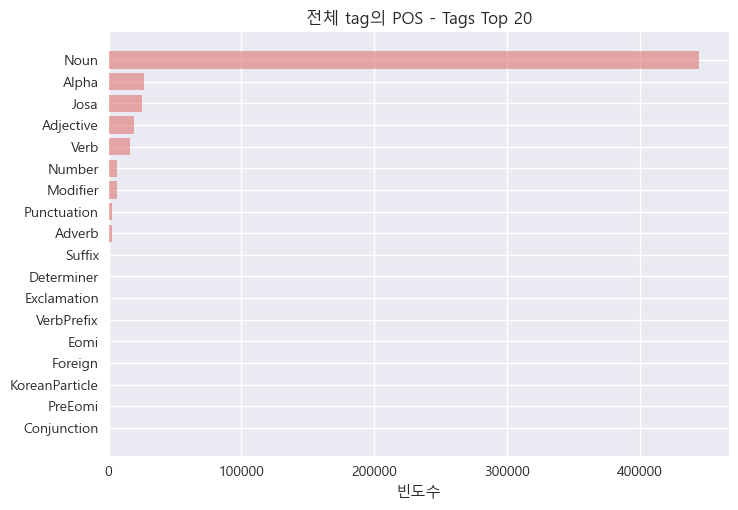

In [12]:
objects = [x[0] for x in popular_pos[:20]]
y_pos = np.arange(len(objects))
performance = [x[1] for x in popular_pos[:20]]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.gca().invert_yaxis()
plt.xlabel('빈도수')
plt.title('전체 tag의 POS - Tags Top 20')

plt.show()

## 플레이리스트 제목 전처리 및 형태소 분석

In [ ]:
# 일반명사인 NNG, 고유명사인 NNP, 외국어인 SL